### Notebook to compute intrinsic alignments of dark matter halos from the N-body simulation AbacusSummit

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy import units as u

import treecorr

from scipy.ndimage import gaussian_filter

### Cosmological parameters

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) ; h=0.7

### Function required for further work

In [3]:
# Computing complex elipticity
def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

# Format ellipsoid parameters to match Abacus (eigenvectors and values must be in order of least to greatest)
def format_ellipsoid(eigenvectors, eigenvalues, position = np.asarray([0,0,0])):
    
    el = Table()
    el['sigman_eigenvecsMin_L2com'] = eigenvectors[0]
    el['sigman_eigenvecsMid_L2com'] = eigenvectors[1]
    el['sigman_eigenvecsMaj_L2com'] = eigenvectors[2]
    
    el['sigman_L2com'] = np.sqrt(eigenvalues)
    
    return el

### Abacus halos (z=0.575)

Snapshot z=0.575, box of size 2 Gpc, base_c000_ph000

In [38]:
# Halo catalog 
halos_table = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/Abacus_halos/Abacus_halos_z0.575_high_mass.fits')
halos_table


# Selecting a certain number of halo
nb_halos=200_000

random_indices = np.random.choice(len(halos_table), size=nb_halos, replace=False)
halos_table = halos_table[random_indices]


# Positions in 3D
x = halos_table['x_L2com'][:,0] * u.Mpc
y = halos_table['x_L2com'][:,1] * u.Mpc
z = halos_table['x_L2com'][:,2] * u.Mpc

x_val = x.value ; y_val = y.value ; z_val = z.value



# Storing the mass of one dark matter particle (in solar mass)
m_part = 2*10**9 / 0.7

### Random halos

In [39]:
random_halos_table = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/Abacus_halos/Abacus_random_halos.fits')
random_halos_table


nb_random_halos=200_000

random_indices = np.random.choice(len(random_halos_table), size=nb_random_halos, replace=False)
random_halos_table = random_halos_table[random_indices]

x = random_halos_table['x_L2com'][:,0] * u.Mpc
y = random_halos_table['x_L2com'][:,1] * u.Mpc
z = random_halos_table['x_L2com'][:,2] * u.Mpc

x_rand = x.value ; y_rand = y.value ; z_rand = z.value

### Visualisation of the halos in 3D

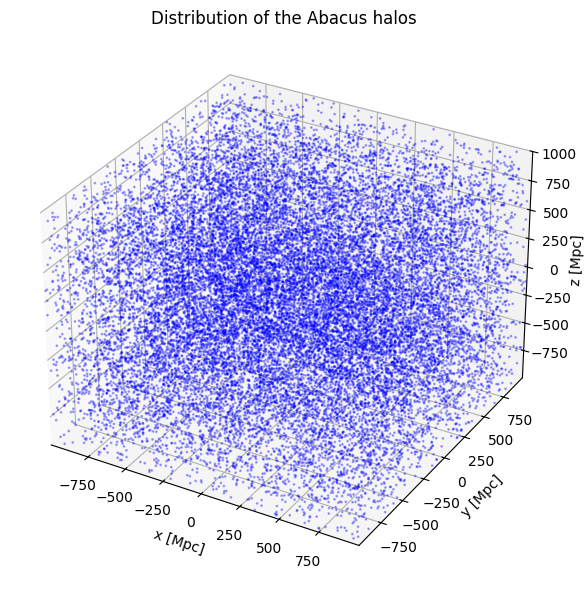

In [31]:
# Définir les bornes du cube
x_min, x_max = x_val.min(), x_val.max()
y_min, y_max = y_val.min(), y_val.max()
z_min, z_max = z_val.min(), z_val.max()

# --- Figure 3D ---
fig = plt.figure(figsize=(100,6))
ax = fig.add_subplot(111, projection='3d')

# Nuage de points
ax.scatter(x_val, y_val, z_val, s=1, c='blue', alpha=0.3)

# Définir les limites du cube
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

# Labels
ax.set_xlabel('x [Mpc]')
ax.set_ylabel('y [Mpc]')
ax.set_zlabel('z [Mpc]', labelpad=1)
ax.set_title('Distribution of the Abacus halos')

# Aspect cube (même échelle sur les 3 axes)
max_range = np.array([x_max-x_min, y_max-y_min, z_max-z_min]).max() / 2.0
mid_x = (x_max+x_min) * 0.5
mid_y = (y_max+y_min) * 0.5
mid_z = (z_max+z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.show()

### Model : population of halos by galaxies

In [32]:
# Function to generate a population of galaxies that live into Abacus halos
# Returns the eigenvectors inherited from the host-halos and the eigenvalues modified by the tau_B and tau_C parameters

def population_3D (mu_tau_B, mu_tau_C, 
                   sigma_tau_B, sigma_tau_C, 
                   r_tau,
                   el=halos_table, 
                   nb_halos=nb_halos) : 

    halos_table2 = el.copy()
    axis_orig = np.array(halos_table2['sigman_L2com']**2)

    valid_axis = []

    while len(valid_axis) < nb_halos:

        taus = np.random.multivariate_normal(mean=[mu_tau_B, mu_tau_C], 


                                    cov=[
                            [sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],
                            [r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2],
                            ],

                                    size=nb_halos)

        tau_B2 = np.clip(taus[:, 0], 0, 1)
        tau_C2 = np.clip(taus[:, 1], 0, 1)

        axis = axis_orig.copy()
        axis[:, 1] *= tau_B2
        axis[:, 2] *= tau_C2

        Ag, Bg, Cg = axis[:, 0], axis[:, 1], axis[:, 2]
        mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)

        filtered = axis[mask]

        to_add = min(nb_halos - len(valid_axis), filtered.shape[0])
        valid_axis.extend(filtered[:to_add])


    axis = np.array(valid_axis) 
   
    
    eigenvecs_Min = halos_table2['sigman_eigenvecsMin_L2com'][:len(axis)]
    eigenvecs_Mid = halos_table2['sigman_eigenvecsMid_L2com'][:len(axis)]
    eigenvecs_Max = halos_table2['sigman_eigenvecsMaj_L2com'][:len(axis)]

    eigenvectors = np.stack((eigenvecs_Min, eigenvecs_Mid, eigenvecs_Max), axis=1)

    ellipsoids = np.array([format_ellipsoid(eigenvectors[i, :, :], axis[i, :]) for i in range(nb_halos)])
    ellipsoids = np.array(ellipsoids)

    evcl = np.array([ellipsoids['sigman_eigenvecsMaj_L2com'], ellipsoids['sigman_eigenvecsMid_L2com'], ellipsoids['sigman_eigenvecsMin_L2com']])
    evcl=np.transpose(evcl, (1, 0, 2))
    axis_lengths = ellipsoids['sigman_L2com']**2 

    
    return evcl, axis_lengths

### Projection of 3D halo shapes in 2D

In [33]:
def projection (evcl, evls, p_axis=''):

    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C (eq 23 of (2))
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


    # Projected ellipticity
    e1, e2 = e_complex(a_p, b_p, r_p)

    return e1, e2

### Simulator (model => $e_1,e_2$)

In [40]:
# Function to compute the projected ellipticities of the halos after projection of their 3D shape


def simulator(theta, 
                el=halos_table,
                nb_halos=nb_halos, 
                p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
               ):

    mu_tau_B, mu_tau_C, sigma_tau_B, sigma_tau_C, r_tau = theta

    evcl, evls = population_3D (mu_tau_B, mu_tau_C, sigma_tau_B, sigma_tau_C, r_tau, el, nb_halos)

    e1, e2 = projection (evcl, evls, p_axis) 

    
    return e1, e2



e1_halos, e2_halos = simulator([1,1,0,0,0], el=halos_table)


halos_table['e1']= e1_halos ; halos_table['e2']= e2_halos

### Computing halo intrinsic alignments (using TreeCorr https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)

In [45]:
# Function that computes the 2-point correlation function xi_g+ and xi_gx for the Abacus halos projected shapes and the associated variances (using Jackknife)

def compute_halo_intrinsic_alignments (x_shape, y_shape, z_shape,
                                       e1_halos, e2_halos, 

                                       x_rand, y_rand, z_rand,

                                       pi_max = 60, 
                                         
                                       rp_min=0.1, rp_max = 60.,

                                       bin_type='Linear',
                                        
                                       nrp=25, npi=50,
                                       
                                       npatch=20):
    
    # Catalog of halos
    halo_shapes = treecorr.Catalog(x=x_shape, y=y_shape, z=z_shape, g1=e1_halos, g2=e2_halos, npatch=npatch)
    halo_randoms = treecorr.Catalog(x=x_rand, y=y_rand, z=z_rand, npatch=npatch)

    # Line-of-sight direction
    pi = np.linspace(-pi_max, pi_max, npi)

    xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
    var = [] ; var = list(var) ; rp = [] ; rp = list(rp)

    for i in np.arange(0, npi-1):

        ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = rp_min,
                                max_sep = rp_max,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type=bin_type,
                                bin_slop=0.1,
                                angle_slop=0.1,
                                var_method='jackknife',
                                cross_patch_weight='simple')
        ng.process(halo_shapes, halo_shapes, metric ='Rperp')

        rg = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = rp_min,
                                max_sep = rp_max,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type=bin_type,
                                bin_slop=0.1,
                                angle_slop=0.1,
                                var_method='jackknife',
                                cross_patch_weight='simple')
        rg.process(halo_randoms, halo_shapes, metric ='Rperp')

        xi_p, xi_c, var2 = ng.calculateXi(rg=None) ; r=ng.meanr

        xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r)

    xi_gp_halos=np.array(xi_gp) ; xi_gc_halos=np.array(xi_gc) ; var_halos = np.array(var) ; r_halos = np.array(rp)

    return xi_gp_halos, xi_gc_halos, var_halos, r_halos

In [46]:
xi_gp_halos, xi_gc_halos, var_halos, r_halos = compute_halo_intrinsic_alignments (x_val, y_val, z_val, 
                                                                                  e1_halos, e2_halos, 
                                                                                  
                                                                                  x_rand, y_rand, z_rand,

                                                                                  pi_max = 60, 
                                         
                                                                                  rp_min=0.1, rp_max = 60.,

                                                                                  bin_type='Linear',
                                        
                                                                                  nrp=25, npi=50,
                                       
                                                                                  npatch=20)

### Plotting the correlation functions $\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$ and $\xi_{\mathrm{g\times}}(r_\mathrm{p},\Pi)$

### $\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi) = \frac{S_+D - S_+R_D}{R_DR_S}$

### $\xi_{\mathrm{g\times}}(r_\mathrm{p},\Pi) = \frac{S_\times D - S_\times R_D}{R_DR_S}$

In [49]:
# Function to plot the correlation functions in the rp-Pi plane

def plotting_correlation_function(xi_gn_p_results, xi_gn_x_results, rmin=60, sigma=2, 
                                  contourf=True, vmin=None, vmax=None, log=False, title_p='', title_save='', title_x=''):


    smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma=sigma)
    smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma=sigma)

    if log:
        print('do nothing')
    else:
        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results < vmin ] = vmin
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results < vmin ] = vmin

        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results > vmax ] = vmax
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results > vmax ] = vmax



    plt.figure(figsize=(12, 8))


    plt.subplot(121)

    if contourf:
        plt.contourf(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    
    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=13)
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_\mathrm{p}$ [Mpc]', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title_p, fontsize=18)



    plt.subplot(122)
    if contourf:
        plt.contourf(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)

    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=13)
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_\mathrm{p}$ [Mpc]', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title_x, fontsize=18)

    plt.tight_layout()
    plt.savefig(title_save, bbox_inches='tight')
    plt.show()

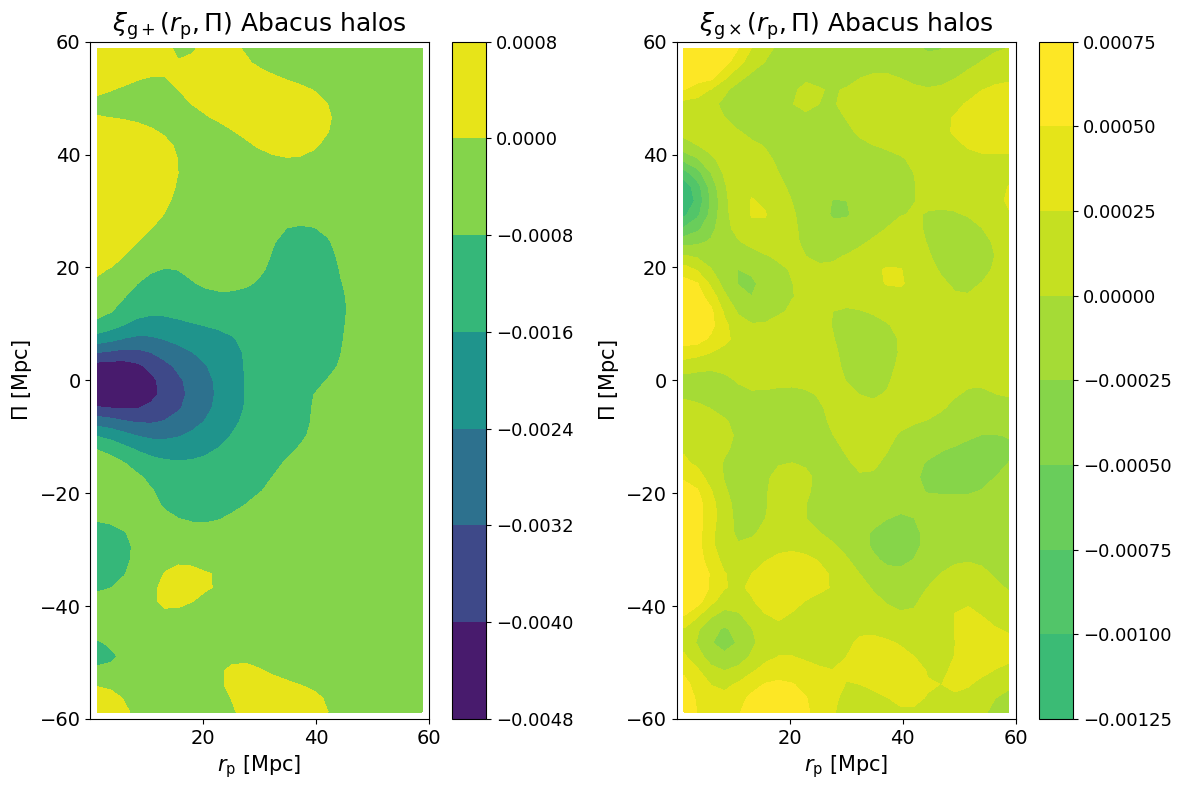

In [50]:
plotting_correlation_function(xi_gp_halos.T, xi_gc_halos.T, rmin=60, sigma=2, 
                              contourf=True, vmin=-0.0048, vmax=0.0006, log=False, 
                              title_p=r'$\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$ Abacus halos', 
                              title_save='Abacus_halos_xi.pdf',
                              title_x=r'$\xi_{\mathrm{g\times}}(r_\mathrm{p},\Pi)$ Abacus halos')

### Computing $w_{\mathrm{g+}}(r_\mathrm{p})$ and $w_{\mathrm{g\times}}(r_\mathrm{p})$

$w_{\mathrm{g+}}(r_\mathrm{p}) = \int_{-\Pi_{\mathrm{max}}}^{\Pi_{\mathrm{max}}}d\Pi~\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$

$w_{\mathrm{g\times}}(r_\mathrm{p}) = \int_{-\Pi_{\mathrm{max}}}^{\Pi_{\mathrm{max}}}d\Pi~\xi_{\mathrm{g\times}}(r_\mathrm{p},\Pi)$

In [ ]:
xi_gp_halos, xi_gc_halos, var_halos, r_halos = compute_halo_intrinsic_alignments (x_val, y_val, z_val, 
                                                                                  e1_halos, e2_halos, 
                                                                                  
                                                                                  x_rand, y_rand, z_rand,

                                                                                  pi_max = 20, 
                                         
                                                                                  rp_min=0.1, rp_max = 200.,

                                                                                  bin_type='Log',
                                        
                                                                                  nrp=25, npi=50,
                                       
                                                                                  npatch=20)

nrp=25

wgp_halos = np.zeros(nrp) ; sum_var_gp_halos=np.zeros(nrp)
wgc_halos = np.zeros(nrp) ; sum_var_gc_halos=np.zeros(nrp)

# Summing over bins of Pi to get the projected correlation functions w_g+ and w_gx
for i in range (nrp):
    wgp_halos[i] = abs(np.sum(xi_gp_halos[:,i])) ; sum_var_gp_halos[i]= np.sum(var_halos[:,i])
    wgc_halos[i] = abs(np.sum(xi_gc_halos[:,i])) ; sum_var_gc_halos[i]= np.sum(var_halos[:,i])


sigma_gp_halos = np.sqrt(sum_var_gp_halos)
sigma_gc_halos = np.sqrt(sum_var_gc_halos)

### Plotting $r_\mathrm{p}\times w_{\mathrm{g+}}(r_\mathrm{p})$ and $r_\mathrm{p}\times w_{\mathrm{g\times}}(r_\mathrm{p})$

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_90898/1614629315.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


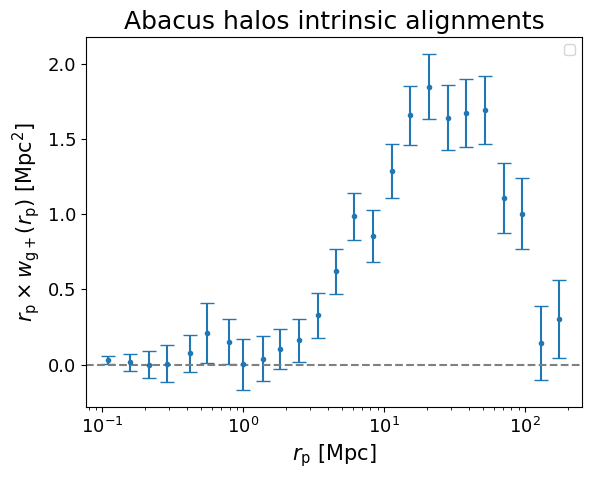

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_90898/1614629315.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


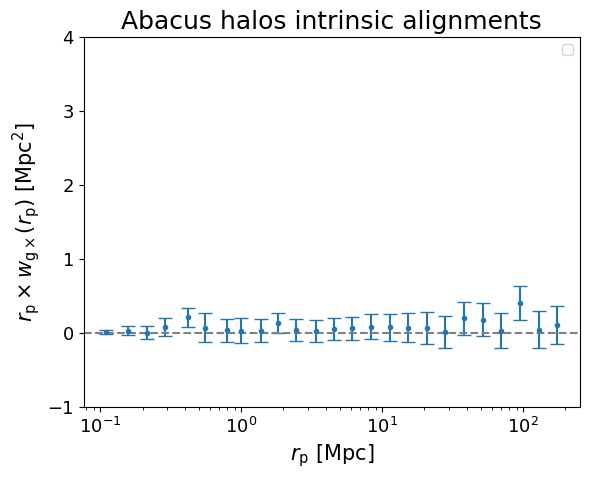

In [53]:
plt.errorbar(r_halos[0,:], r_halos[0,:]*wgp_halos, yerr= r_halos[0,:]*sigma_gp_halos, fmt='o', markersize=3, capsize=5)
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments", fontsize=18)
plt.savefig('Abacus_halos_wgp.pdf', bbox_inches='tight')
plt.show()



plt.errorbar(r_halos[0,:], r_halos[0,:]*wgc_halos, yerr= r_halos[0,:]*sigma_gc_halos, fmt='o', markersize=3, capsize=5)
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}$]', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g\times}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments", fontsize=18)
plt.savefig('Abacus_halos_wgc.pdf', bbox_inches='tight')
plt.show()

### Halo intrinsic alignments by ranges of masses

Low masses: $[10^9$ ; $10^{11}]~\mathrm{M}_{\odot}$

In [59]:
halos_table_low = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/Abacus_halos/Abacus_halos_z0.575_low_mass.fits')
halos_table_low

nb_halos_low = len(halos_table_low)


nb_halos=200_000

random_indices = np.random.choice(len(halos_table_low), size=nb_halos, replace=False)
halos_table_low = halos_table_low[random_indices]



x = halos_table_low['x_L2com'][:,0] * u.Mpc
y = halos_table_low['x_L2com'][:,1] * u.Mpc
z = halos_table_low['x_L2com'][:,2] * u.Mpc

x_low = x.value ; y_low = y.value ; z_low = z.value

e1_halos_low, e2_halos_low = simulator([1,1,0,0,0], el=halos_table_low)



xi_gp_halos_low, xi_gc_halos_low, var_halos_low, r_halos_low = compute_halo_intrinsic_alignments (x_low, y_low, z_low, 
                                                                                                e1_halos_low, e2_halos_low, 

                                                                                                x_rand, y_rand, z_rand,

                                                                                                nrp=25, npi=50,

                                                                                                pi_max = 20, 
                                         
                                                                                                rp_min=0.1, rp_max = 200.,
                                       
                                                                                                npatch=20,
                                                                                  
                                                                                                bin_type='Log')

nrp=25

wgp_halos_low = np.zeros(nrp) ; sum_var_gp_halos_low=np.zeros(nrp)
wgc_halos_low = np.zeros(nrp) ; sum_var_gc_halos_low=np.zeros(nrp)

for i in range (nrp):
    wgp_halos_low[i] = abs(np.sum(xi_gp_halos_low[:,i])) ; sum_var_gp_halos_low[i]= np.sum(var_halos_low[:,i])
    wgc_halos_low[i] = abs(np.sum(xi_gc_halos_low[:,i])) ; sum_var_gc_halos_low[i]= np.sum(var_halos_low[:,i])


sigma_gp_halos_low = np.sqrt(sum_var_gp_halos_low)
sigma_gc_halos_low = np.sqrt(sum_var_gc_halos_low)

Intermediate masses: $[10^{11} ; 10^{13}]~\mathrm{M}_{\odot}$

In [61]:
halos_table_mid = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/Abacus_halos/Abacus_halos_z0.575_mid_mass.fits')
halos_table_mid['N']

nb_halos_mid = len(halos_table_mid)


nb_halos=200_000

random_indices = np.random.choice(len(halos_table_mid), size=nb_halos, replace=False)
halos_table_mid = halos_table_mid[random_indices]


x = halos_table_mid['x_L2com'][:,0] * u.Mpc
y = halos_table_mid['x_L2com'][:,1] * u.Mpc
z = halos_table_mid['x_L2com'][:,2] * u.Mpc

x_mid = x.value ; y_mid = y.value ; z_mid = z.value

e1_halos_mid, e2_halos_mid = simulator([1,1,0,0,0], el=halos_table_mid)



xi_gp_halos_mid, xi_gc_halos_mid, var_halos_mid, r_halos_mid = compute_halo_intrinsic_alignments (x_mid, y_mid, z_mid, 
                                                                                                e1_halos_mid, e2_halos_mid,

                                                                                                x_rand, y_rand, z_rand, 

                                                                                                nrp=25, npi=50,

                                                                                                pi_max = 20, 
                                         
                                                                                                rp_min=0.1, rp_max = 200.,
                                       
                                                                                                npatch=20,
                                                                                  
                                                                                                bin_type='Log')

nrp=25

wgp_halos_mid = np.zeros(nrp) ; sum_var_gp_halos_mid=np.zeros(nrp)
wgc_halos_mid = np.zeros(nrp) ; sum_var_gc_halos_mid=np.zeros(nrp)


for i in range (nrp):
    wgp_halos_mid[i] = abs(np.sum(xi_gp_halos_mid[:,i])) ; sum_var_gp_halos_mid[i]= np.sum(var_halos_mid[:,i])
    wgc_halos_mid[i] = abs(np.sum(xi_gc_halos_mid[:,i])) ; sum_var_gc_halos_mid[i]= np.sum(var_halos_mid[:,i])


sigma_gp_halos_mid = np.sqrt(sum_var_gp_halos_mid)
sigma_gc_halos_mid = np.sqrt(sum_var_gc_halos_mid)

High masses: $[10^{13} ; 10^{15}]~\mathrm{M}_{\odot}$

In [62]:
halos_table_high = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/Abacus_halos/Abacus_halos_z0.575_high_mass.fits')
halos_table_high

nb_halos_high = len(halos_table_high)


nb_halos=200_000

random_indices = np.random.choice(len(halos_table_high), size=nb_halos, replace=False)
halos_table_high = halos_table_high[random_indices]



x = halos_table_high['x_L2com'][:,0] * u.Mpc
y = halos_table_high['x_L2com'][:,1] * u.Mpc
z = halos_table_high['x_L2com'][:,2] * u.Mpc

x_high = x.value ; y_high = y.value ; z_high = z.value

e1_halos_high, e2_halos_high = simulator([1,1,0,0,0], el=halos_table_high, nb_halos=len(halos_table_high))



xi_gp_halos_high, xi_gc_halos_high, var_halos_high, r_halos_high = compute_halo_intrinsic_alignments (x_high, y_high, z_high, 
                                                                                                    e1_halos_high, e2_halos_high, 

                                                                                                    x_rand, y_rand, z_rand, 

                                                                                                    nrp=25, npi=50,

                                                                                                    pi_max = 20, 
                                         
                                                                                                    rp_min=0.1, rp_max = 200.,
                                       
                                                                                                    npatch=20,
                                                                                  
                                                                                                    bin_type='Log')

nrp=25

wgp_halos_high = np.zeros(nrp) ; sum_var_gp_halos_high=np.zeros(nrp)
wgc_halos_high = np.zeros(nrp) ; sum_var_gc_halos_high=np.zeros(nrp)


for i in range (nrp):
    wgp_halos_high[i] = abs(np.sum(xi_gp_halos_high[:,i])) ; sum_var_gp_halos_high[i]= np.sum(var_halos_high[:,i])
    wgc_halos_high[i] = abs(np.sum(xi_gc_halos_high[:,i])) ; sum_var_gc_halos_high[i]= np.sum(var_halos_high[:,i])


sigma_gp_halos_high = np.sqrt(sum_var_gp_halos_high)
sigma_gc_halos_high = np.sqrt(sum_var_gc_halos_high)

Every masses: $[10^{9} ; 10^{15}]~\mathrm{M}_{\odot}$

In [63]:
halos_table_all = Table.read('/Users/antonincorinaldi/Documents/Thèse_2025_2028/3D_intrinsic_alignment/data/Abacus_halos/Abacus_halos_z0.575_all_mass.fits')
halos_table_all

nb_halos_all = len(halos_table_all)


nb_halos=200_000

random_indices = np.random.choice(len(halos_table_all), size=nb_halos, replace=False)
halos_table_all = halos_table_all[random_indices]



x = halos_table_all['x_L2com'][:,0] * u.Mpc
y = halos_table_all['x_L2com'][:,1] * u.Mpc
z = halos_table_all['x_L2com'][:,2] * u.Mpc

x_all = x.value ; y_all = y.value ; z_all = z.value

e1_halos_all, e2_halos_all = simulator([1,1,0,0,0], el=halos_table_all, nb_halos=len(halos_table_all))



xi_gp_halos_all, xi_gc_halos_all, var_halos_all, r_halos_all = compute_halo_intrinsic_alignments (x_all, y_all, z_all, 
                                                                                                e1_halos_all, e2_halos_all, 

                                                                                                x_rand, y_rand, z_rand,

                                                                                                nrp=25, npi=50,

                                                                                                pi_max = 20, 
                                         
                                                                                                rp_min=0.1, rp_max = 200.,
                                       
                                                                                                npatch=20,
                                                                                  
                                                                                                bin_type='Log')

nrp=25

wgp_halos_all = np.zeros(nrp) ; sum_var_gp_halos_all=np.zeros(nrp)
wgc_halos_all = np.zeros(nrp) ; sum_var_gc_halos_all=np.zeros(nrp)


for i in range (nrp):
    wgp_halos_all[i] = abs(np.sum(xi_gp_halos_all[:,i])) ; sum_var_gp_halos_all[i]= np.sum(var_halos_all[:,i])
    wgc_halos_all[i] = abs(np.sum(xi_gc_halos_all[:,i])) ; sum_var_gc_halos_all[i]= np.sum(var_halos_all[:,i])


sigma_gp_halos_all = np.sqrt(sum_var_gp_halos_all)
sigma_gc_halos_all = np.sqrt(sum_var_gc_halos_all)

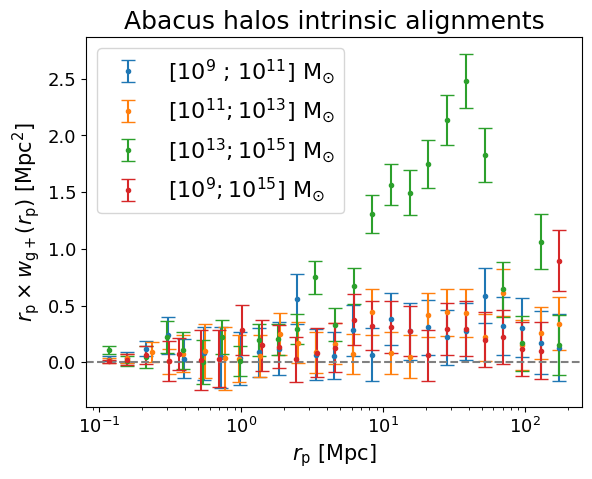

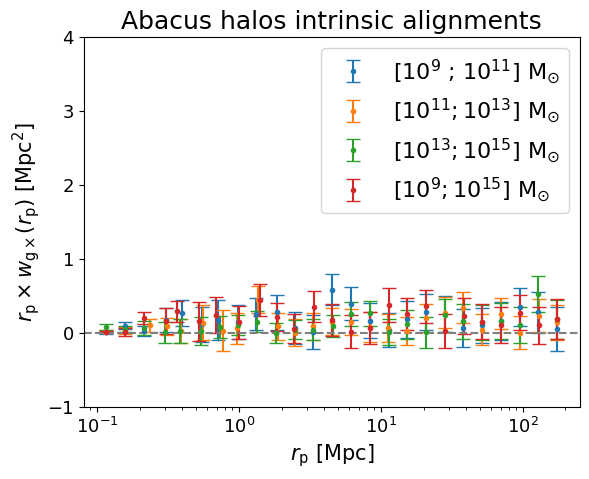

In [64]:
plt.errorbar(r_halos_low[0,:], r_halos_low[0,:]*wgp_halos_low, yerr= r_halos_low[0,:]*sigma_gp_halos_low, fmt='o', markersize=3, capsize=5, label=r'$[10^9$ ; $10^{11}]~\mathrm{M}_{\odot}$')
plt.errorbar(r_halos_mid[0,:], r_halos_mid[0,:]*wgp_halos_mid, yerr= r_halos_mid[0,:]*sigma_gp_halos_mid, fmt='o', markersize=3, capsize=5, label=r'$[10^{11} ; 10^{13}]~\mathrm{M}_{\odot}$')
plt.errorbar(r_halos_high[0,:], r_halos_high[0,:]*wgp_halos_high, yerr= r_halos_high[0,:]*sigma_gp_halos_high, fmt='o', markersize=3, capsize=5, label=r'$[10^{13} ; 10^{15}]~\mathrm{M}_{\odot}$')
plt.errorbar(r_halos_all[0,:], r_halos_all[0,:]*wgp_halos_all, yerr= r_halos_all[0,:]*sigma_gp_halos_all, fmt='o', markersize=3, capsize=5, label=r'$[10^{9} ; 10^{15}]~\mathrm{M}_{\odot}$')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments", fontsize=18)
plt.savefig('Abacus_halos_wgp_mass_ranges.pdf', bbox_inches='tight')
plt.legend(fontsize=16)
plt.show()



plt.errorbar(r_halos_low[0,:], r_halos_low[0,:]*wgc_halos_low, yerr= r_halos_low[0,:]*sigma_gc_halos_low, fmt='o', markersize=3, capsize=5, label=r'$[10^9$ ; $10^{11}]~\mathrm{M}_{\odot}$')
plt.errorbar(r_halos_mid[0,:], r_halos_mid[0,:]*wgc_halos_mid, yerr= r_halos_mid[0,:]*sigma_gc_halos_mid, fmt='o', markersize=3, capsize=5, label=r'$[10^{11} ; 10^{13}]~\mathrm{M}_{\odot}$')
plt.errorbar(r_halos_high[0,:], r_halos_high[0,:]*wgc_halos_high, yerr= r_halos_high[0,:]*sigma_gc_halos_high, fmt='o', markersize=3, capsize=5, label=r'$[10^{13} ; 10^{15}]~\mathrm{M}_{\odot}$')
plt.errorbar(r_halos_all[0,:], r_halos_all[0,:]*wgc_halos_all, yerr= r_halos_all[0,:]*sigma_gc_halos_all, fmt='o', markersize=3, capsize=5, label=r'$[10^{9} ; 10^{15}]~\mathrm{M}_{\odot}$')
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}$]', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g\times}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments", fontsize=18)
plt.savefig('Abacus_halos_wgc_mass_ranges.pdf', bbox_inches='tight')
plt.legend(fontsize=16)
plt.show()